<a href="https://colab.research.google.com/github/Swathi1309/ED18B034_ME18B133_CS6910/blob/main/Assignment3/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow
from tensorflow import keras
from keras import Model
from keras.layers import SimpleRNN, LSTM, GRU, Dense

In [ ]:
def encoder(X_input_enc,in_token_no,enc_block, latent_dim):
  
  if enc_block =='LSTM':
    enc_out ,h ,s = LSTM(latent_dim, return_state=True)(X_input_enc)
  elif enc_block =='GRU':
    enc_out ,h ,s = GRU(latent_dim, return_state=True)(X_input_enc)
  else:
    enc_out ,h ,s = SimpleRNN(latent_dim, return_state=True)(X_input_enc)

  return enc_out,h,s


In [ ]:
def decoder(X_input_dec, hs_init, latent_dim, out_token_no, dec_block):
  

  if dec_block == 'LSTM':
    out_dec, _, _ = LSTM(latent_dim, return_sequences=True, return_state=True)(X_input_dec, initial_state = hs_init)
  elif dec_block == 'GRU':
    out_dec, _, _ = GRU(latent_dim, return_sequences=True, return_state=True)(X_input_dec, initial_state = hs_init)
  else:
    out_dec, _, _ = SimpleRNN(latent_dim, return_sequences=True, return_state=True)(X_input_dec, initial_state = hs_init)
  
  out_dec = Dense(out_token_no, activation="softmax")(out_dec)

  return out_dec

In [ ]:
def RNN_model(in_token_no, enc_block, latent_dim, out_token_no, dec_block):
  X_input_enc = keras.Input(shape=(None, in_token_no))
  X_input_dec = keras.Input(shape=(None, out_token_no))
  _,h_init,s_init = encoder(X_input_enc,in_token_no,enc_block,latent_dim)
  out_dec = decoder(X_input_dec,[h_init,s_init],latent_dim, out_token_no, dec_block)
  model = Model(inputs = [X_input_enc,X_input_dec], outputs = out_dec)

  return model

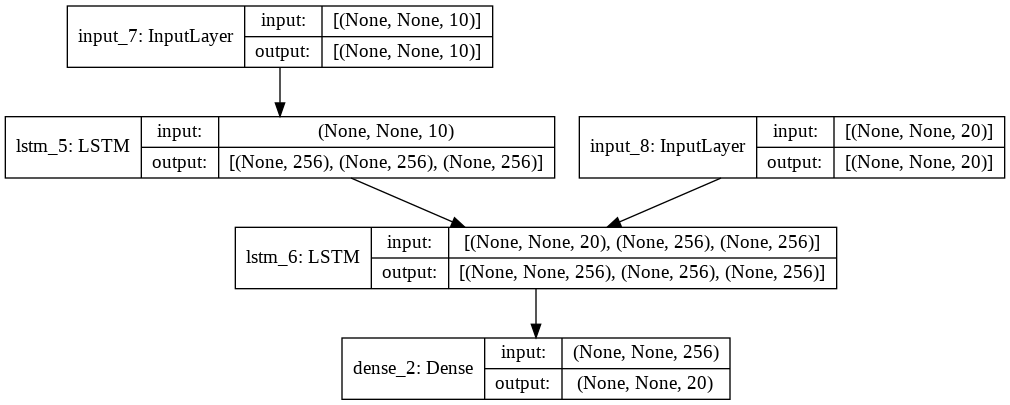

In [ ]:
model = RNN_model(10,'LSTM',256,20,'LSTM')
keras.utils.plot_model(model,show_shapes=True)

In [ ]:
def enc_inference(model):
  X_in_enc = model.input[0]
  enc_out ,h ,s = model.layers[2].output
  X_out_enc = [h,s]
  enc_model = keras.Model(inputs = X_in_enc, outputs = X_out_enc)

  return enc_model

def dec_inference(model):
  dec_inputs = model.input[1]
  dec_input_h = keras.Input(shape=(latent_dim,))
  dec_input_s = keras.Input(shape=(latent_dim,))
  hs_inputs = [dec_input_h,dec_input_s]
  dec_model = model.layers[3]
  dec_outputs, h_dec, s_dec = dec_model(dec_inputs, initial_state=hs_inputs)
  hs_outputs = [h_dec, s_dec]
  dec_dense = model.layers[4]
  dec_outputs = dec_dense(dec_outputs)
  dec_model = keras.Model(inputs = [dec_inputs] + hs_inputs, outputs = [decoder_outputs]
                              + hs_outputs)
  
  return dec_model


In [ ]:
global input_tokens
global output_tokens

In [ ]:
sweep_config = {
    'method': 'grid'
    }

parameters_dict = {
    'encoder_block':{
        'values': ['RNN', 'LSTM', 'GRU']
      },
    'encoder_layers': {
        'values': [1,2,3]
      },
    'decoder_block':{
      'values' : ['RNN', 'LSTM', 'GRU']
      },
    'decoder_layers': {
        'values': [1,2,3]
      },
    'hidden_layer': {
        'values': [128,256,512]
      },
    'dropout': {
        'values': [0, 0.2, 0.3]
      },
    'epochs' : {
        'values' : [20,30]
    }
}

sweep_config['parameters'] = parameters_dict
pprint.pprint(sweep_config)

def training_sweep(config=None):
    with wandb.init(config=config):
        config = wandb.config
        model = RNN_model(input_tokens, config.encoder_block, config.hidden_layer, output_tokens, config.decoder_block)
        history = model.fit(train_dataset, 
                            epochs=config.epochs,
                            validation_data = val_dataset,
                            callbacks = [WandbCallback(data_type='image', labels = classes)]
                            )
        name = str(config.encoder_block) + '_' + str(config.encoder_layers) + '_' + str(config.decoder_block) + '_' + str(config.decoder_layers) + '_' + str(config.hidden_layer) + '_' + str(config.dropout) + '_' + str(config.epochs)
        location = '/content/drive/MyDrive/' + name
        model.save(location)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="CS6910-assg1")
wandb.agent(sweep_id, training_sweep)